# Load Data

In [1]:
import pickle

In [2]:
with open('/project_final/orbitals.pkl', 'rb') as f:
    orbitals = pickle.load(f)

with open('/project_final/maneuvers.pkl', 'rb') as f:
    maneuvers = pickle.load(f)

# Check day time uniform and interpolate

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [4]:
man = maneuvers['srl']

In [5]:
df = orbitals['SARAL.csv'].copy()
df = df[['Brouwer mean motion']].copy()
df.rename(columns={"Brouwer mean motion": "mean_motion"}, inplace=True)

In [6]:
df.index = pd.to_datetime(df.index)

# keep only year-month-day
df.index = df.index.normalize()

# Set up random environment

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os
from itertools import product
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [8]:
def set_seed(seed=42):
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed(42)

In [9]:
def create_sequences(data, window_size):
    sequences, targets = [], []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
        targets.append(data[i+window_size][0])
    return np.array(sequences), np.array(targets)

In [10]:
def create_lstm_model(window_size, n_features, learning_rate, hidden_units, dropout_rate, fc_size):
    model = Sequential()
    model.add(Input(shape=(window_size, n_features)))
    model.add(LSTM(hidden_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(fc_size, activation='tanh'))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae')
    return model

# Split data and pre-process

In [11]:
data = df['mean_motion']

train_size = int(len(data) * 0.8)
train_data = data[:train_size]
val_data = data[train_size:]

train_index = df.index[:train_size]
val_index = df.index[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.values.reshape(-1,1))
val_scaled = scaler.transform(val_data.values.reshape(-1,1))

train_scaled_series = pd.Series(train_scaled.flatten(), index=train_index, name='mean_motion_scaled_train')
val_scaled_series = pd.Series(val_scaled.flatten(), index=val_index, name='mean_motion_scaled_val')

# Tuning learning rate for models

In [12]:
param_grid = {
    'window_size': [3, 5, 7], # 2,3,5,7
    'learning_rate': [0.001],
    'hidden_units': [16, 32, 64],
    'dropout_rate': [0, 0.1, 0.3], # 0, 0.3
    'fc_size': [8, 16] # 8, 16
}

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
callbacks = [early_stop, reduce_lr]

In [14]:
results = []

for window_size, lr, hu, dr, fc in product(
    param_grid['window_size'],
    param_grid['learning_rate'],
    param_grid['hidden_units'],
    param_grid['dropout_rate'],
    param_grid['fc_size']
):
    set_seed(42)
    print(f"Training: window_size={window_size}, lr={lr}, hidden_units={hu}, dropout={dr}, fc_size={fc}")

    X_train, y_train = create_sequences(train_scaled, window_size)
    X_val, y_val = create_sequences(val_scaled, window_size)

    n_features = 1
    X_train = X_train.reshape((X_train.shape[0], window_size, n_features))
    X_val = X_val.reshape((X_val.shape[0], window_size, n_features))

    model = create_lstm_model(window_size, n_features,
                              learning_rate=lr,
                              hidden_units=hu,
                              dropout_rate=dr,
                              fc_size=fc)

    history = model.fit(X_train, y_train,
                        epochs=20,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        shuffle=False,
                        verbose=0)

    y_pred_scaled = model.predict(X_val)
    y_true_scaled = y_val

    y_pred = scaler.inverse_transform(np.hstack([y_pred_scaled, np.zeros((y_pred_scaled.shape[0], n_features - 1))]))[:, 0]
    y_true = scaler.inverse_transform(np.hstack([y_true_scaled.reshape(-1, 1), np.zeros((y_true_scaled.shape[0], n_features - 1))]))[:, 0]
    
    mae = mean_absolute_error(y_true, y_pred)

    results.append({
        'window_size': window_size,
        'learning_rate': lr,
        'hidden_units': hu,
        'dropout_rate': dr,
        'fc_size': fc,
        'mae': mae
    })
    
results_df = pd.DataFrame(results)

Training: window_size=3, lr=0.001, hidden_units=16, dropout=0, fc_size=8
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Training: window_size=3, lr=0.001, hidden_units=16, dropout=0, fc_size=16
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Training: window_size=3, lr=0.001, hidden_units=16, dropout=0.1, fc_size=8
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Training: window_size=3, lr=0.001, hidden_units=16, dropout=0.1, fc_size=16
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Training: window_size=3, lr=0.001, hidden_units=16, dropout=0.3, fc_size=8
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Training: window_size=3, lr=0.001, hidden_units=16, dropout=0.3, fc_size=16
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Training: window_size=3, lr=0.001, hidden_units=32, dropout=0, fc_size=8
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Training: window_size=3, lr=0.001, hidden_units=32, dropout=0, fc_size=16
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Training: window_size=3, lr=0.001, hidden_units=32, dropout=0.1, fc_size=8
21/21 ━━━

In [15]:
results_df.sort_values(by='mae', ascending=True).head(10)

,window_size,learning_rate,hidden_units,dropout_rate,fc_size,mae
13,3,0.001,64,0.0,16,1.349555e-08
15,3,0.001,64,0.1,16,1.475099e-08
32,5,0.001,64,0.1,8,1.521528e-08
14,3,0.001,64,0.1,8,1.570398e-08
2,3,0.001,16,0.1,8,1.581501e-08
0,3,0.001,16,0.0,8,1.657815e-08
34,5,0.001,64,0.3,8,1.708183e-08
7,3,0.001,32,0.0,16,1.709644e-08
9,3,0.001,32,0.1,16,1.719806e-08
1,3,0.001,16,0.0,16,1.854340e-08


In [16]:
best_idx = results_df[results_df['dropout_rate'] == 0.1]['mae'].idxmin()
best_params = results_df.loc[best_idx]

print("\nBest hyperparameters:")
print(best_params)


Best hyperparameters:
window_size      3.000000e+00
learning_rate    1.000000e-03
hidden_units     6.400000e+01
dropout_rate     1.000000e-01
fc_size          1.600000e+01
mae              1.475099e-08
Name: 15, dtype: float64


# Fit with tuned LSTM models

In [17]:
set_seed(42)

In [18]:
combined_scaled = np.vstack([train_scaled, val_scaled])

window_size = int(best_params['window_size'])
X_all, y_all = create_sequences(combined_scaled, window_size)

n_features = 1
X_all = X_all.reshape((X_all.shape[0], window_size, n_features))

In [19]:
# combined_raw = np.concatenate([train_data.values, val_data.values])
# combined_index = train_index.append(val_index)

# scaler_final = MinMaxScaler()
# combined_scaled = scaler_final.fit_transform(combined_raw.reshape(-1,1))

# combined_scaled_series = pd.Series(combined_scaled.flatten(), index=combined_index, name='mean_motion_scaled_all')

# X_all, y_all = create_sequences(combined_scaled, window_size)
# X_all = X_all.reshape((X_all.shape[0], window_size, n_features))

In [20]:
final_model = create_lstm_model(
    window_size, 
    n_features,
    learning_rate=best_params['learning_rate'],
    hidden_units=int(best_params['hidden_units']),
    dropout_rate=best_params['dropout_rate'],
    fc_size=int(best_params['fc_size'])
)

In [21]:
final_model.fit(
    X_all, 
    y_all,
    epochs=20,
    batch_size=32,
    shuffle=False,
    verbose=1
)

Epoch 1/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1578
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0584
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0459
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0441
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0394
Epoch 6/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0367
Epoch 7/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0305
Epoch 8/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0200
Epoch 9/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0194
Epoch 10/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0192
Epoch 11/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0151
Epoch 12/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0203
Epoch 13/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0247
Epoch 14/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0170
Epoch 15/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

In [22]:
pred_all = final_model.predict(X_all).flatten()

103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [23]:
df_pred_all = pd.DataFrame({'prediction': pred_all}, index=df.index[window_size:])

y_all_series = pd.Series(y_all, index=df.index[window_size:])

lstm_pred = pd.DataFrame({
    'actual': y_all_series,
    'pred': df_pred_all['prediction']
})

print(lstm_pred.head())

              actual      pred
day_time                      
2013-03-14  0.254689  0.953302
2013-03-15  0.506356  0.669473
2013-03-16  0.507030  0.525130
2013-03-17  0.503234  0.454300
2013-03-18  0.507655  0.507409


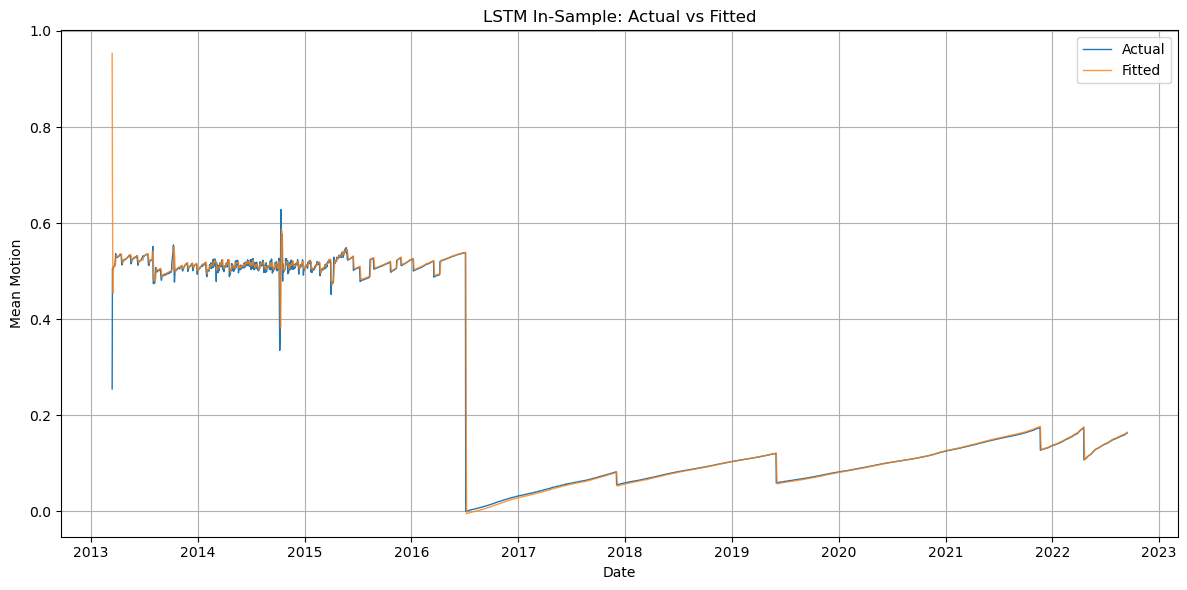

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(lstm_pred.index, lstm_pred["actual"], label="Actual", linewidth=1)
plt.plot(lstm_pred.index, lstm_pred["pred"], label="Fitted", linewidth=1, alpha=0.8)

plt.title("LSTM In‑Sample: Actual vs Fitted")
plt.xlabel("Date")
plt.ylabel("Mean Motion")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

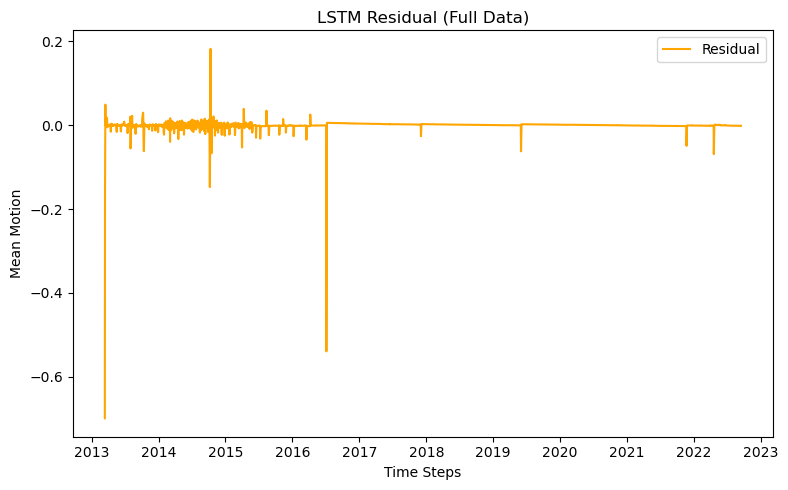

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(lstm_pred['actual'] - lstm_pred['pred'], label='Residual', color='orange')
plt.title('LSTM Residual (Full Data)')
plt.xlabel('Time Steps')
plt.ylabel('Mean Motion')
plt.legend()
plt.tight_layout()
plt.show()

# Get LSTM Residual from prediction vs true value

In [26]:
# xgb_pred['residual_orig'] = xgb_pred['actual_orig'] - xgb_pred['pred_orig']
lstm_pred['residual'] = lstm_pred['actual'] - lstm_pred['pred']

In [27]:
lstm_pred.to_csv("/project_final/result/saral_lstm_residuals.csv", index=True)

# Check residuals - distribution and QQ

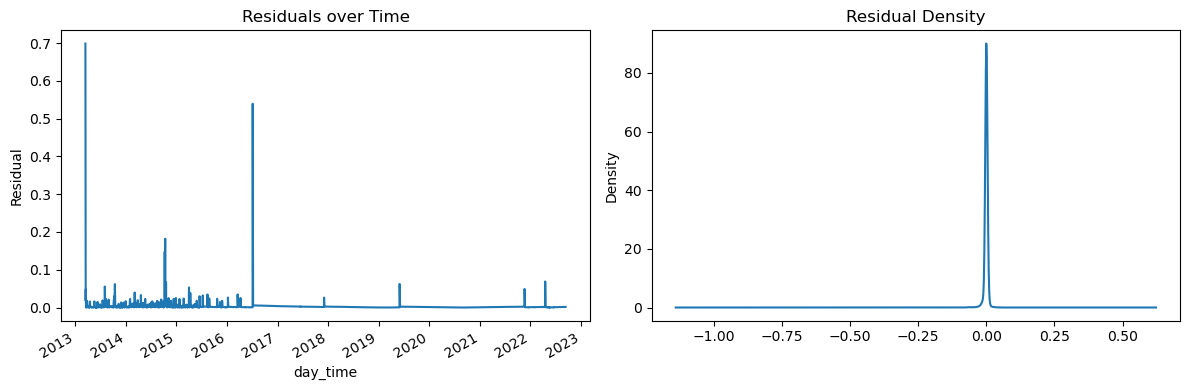

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

np.abs(lstm_pred['residual']).plot(ax=ax[0], title="Residuals over Time")
ax[0].set_ylabel("Residual")

lstm_pred['residual'].plot(kind='kde', ax=ax[1], title="Residual Density")

plt.tight_layout()
plt.show()

In [29]:
import scipy.stats as stats

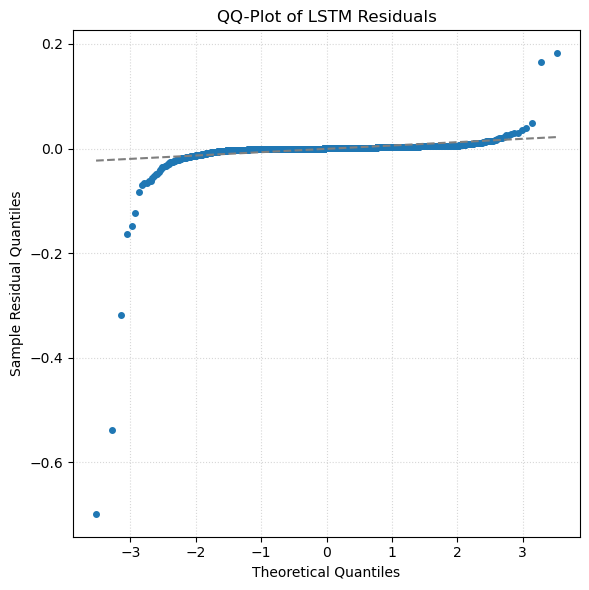

In [30]:
lstm_res = lstm_pred['residual']

# get qq plts for res
fig, ax = plt.subplots(figsize=(6,6))
stats.probplot(lstm_res, dist="norm", plot=ax)

dots, line = ax.get_lines()
dots.set_marker('o')
dots.set_markersize(4)
dots.set_color('tab:blue')

line.set_linestyle('--')
line.set_color('tab:gray')

ax.grid(True, linestyle=':', alpha=0.5)
ax.set_title("QQ-Plot of LSTM Residuals")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Residual Quantiles")

plt.tight_layout()
plt.show()

# Extract anomlies

In [31]:
import scipy.stats as sts

In [32]:
# get means and var for res
mu    = lstm_res.mean()
sigma = lstm_res.std()

In [33]:
# p_low, p_high = sts.norm.cdf([-2.4, +2.5])
# print("percentile range", p_low, p_high)

In [34]:
# # low, high = lstm_res.quantile([p_low, p_high])
# # print("anomlies thresholds selected：", low, high)

# # # get anomalies
# # anomalies = lstm_res[(lstm_res < low) | (lstm_res > high)]
anomalies = lstm_res[np.abs(lstm_res - mu) > 2 * sigma]
print("num of anomalies：", len(anomalies))

num of anomalies： 23


# Visulize result

In [35]:
manoeuvre_dates = pd.to_datetime(man['median_day_time']).dt.date
manoeuvre_dates = pd.to_datetime(manoeuvre_dates)
manoeuvre_dates = manoeuvre_dates[manoeuvre_dates.isin(df.index)]

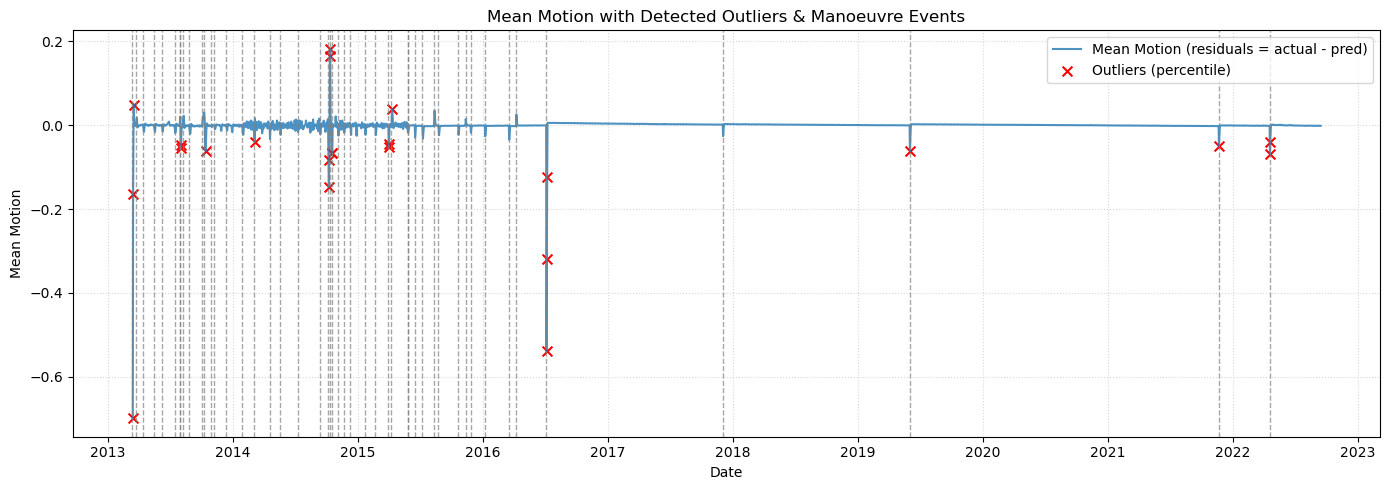

In [36]:
plt.figure(figsize=(14, 5))

# # 1) plt actual
# plt.plot(arima_pred.index, 
#          arima_pred['actual'], 
#          label='Mean Motion (actual)', 
#          color='C0', 
#          alpha=0.8)

# 1) plt -residuals
plt.plot(lstm_pred.index, 
         lstm_pred['residual'], 
         label='Mean Motion (residuals = actual - pred)', 
         color='C0', 
         alpha=0.8)

# 2) plt man
for dt in manoeuvre_dates:
    plt.axvline(x=dt,
                color='gray',
                linestyle='--',
                linewidth=1,
                alpha=0.7)
    
# 3) plt anomalies
plt.scatter(
    anomalies.index,
    lstm_pred.loc[anomalies.index, 'residual'],
    color='red',
    marker='x',
    s=50,
    label='Outliers (percentile)'
)

plt.title("Mean Motion with Detected Outliers & Manoeuvre Events")
plt.xlabel("Date")
plt.ylabel("Mean Motion")
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

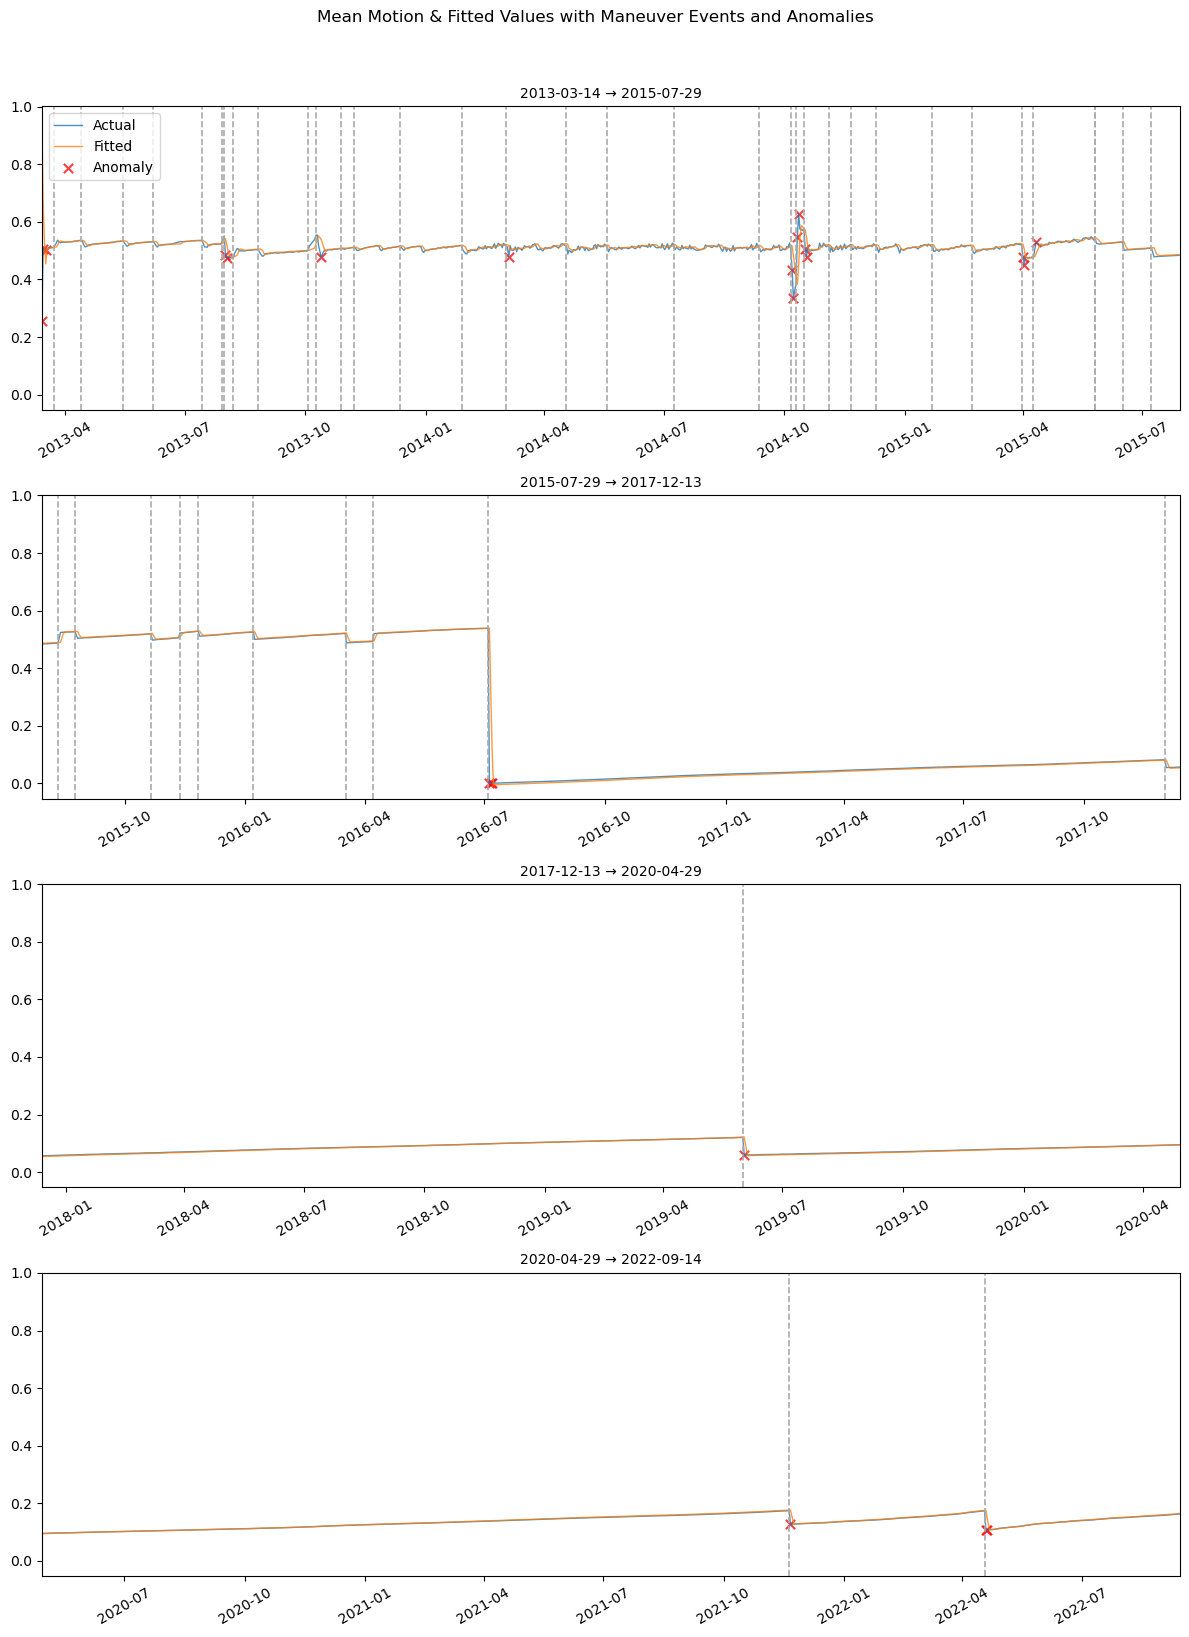

In [37]:
# get multi-cols plts
start, end = lstm_pred.index.min(), lstm_pred.index.max()
knots = pd.date_range(start, end, periods=5)
intervals = list(zip(knots[:-1], knots[1:]))

fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharey=True)

for ax, (seg_start, seg_end) in zip(axes, intervals):
    segment = lstm_pred.loc[seg_start:seg_end]
    
    # actual
    ax.plot(
        segment.index, segment['actual'],
        label='Actual', color='#1f77b4', alpha=0.8, linewidth=1.0
    )
    # plt fitted
    ax.plot(
        segment.index, segment['pred'],
        label='Fitted', color='#ff7f0e', alpha=0.8, linewidth=1.0
    )
    
    # # plt -residuals
    # plt.plot(arima_pred.index, 
	# 		arima_pred['residual'], 
	# 		label='Mean Motion (residuals = actual - pred)', 
	# 		color='C0', 
	# 		alpha=0.8)
    
    # 3) plt anomalies
    idx1 = anomalies.loc[seg_start:seg_end].index
    ax.scatter(
        idx1,
        segment.loc[idx1, 'actual'],
        color='red', 
        marker='x',
        alpha = 0.75,
        s=45,
        label='Anomaly'
    )
    
    # 4) plt man
    for dt in manoeuvre_dates:
        if seg_start <= dt <= seg_end:
            ax.axvline(
                x=dt, color='#aaaaaa',
                linestyle='--', linewidth=1.2, alpha=1.0
            )
    
    # tight layout
    ax.set_xlim(seg_start, seg_end)
    # ax.grid(True, linestyle=':', alpha=0.5)
    ax.set_title(f"{seg_start.date()} → {seg_end.date()}", fontsize=10)
    ax.tick_params(axis='x', rotation=30)
    
    if ax is axes[0]:
        ax.legend(loc='upper left')

fig.suptitle(
    "Mean Motion & Fitted Values with Maneuver Events and Anomalies",
    y=1.02, fontsize=12
)
plt.tight_layout()
plt.show()

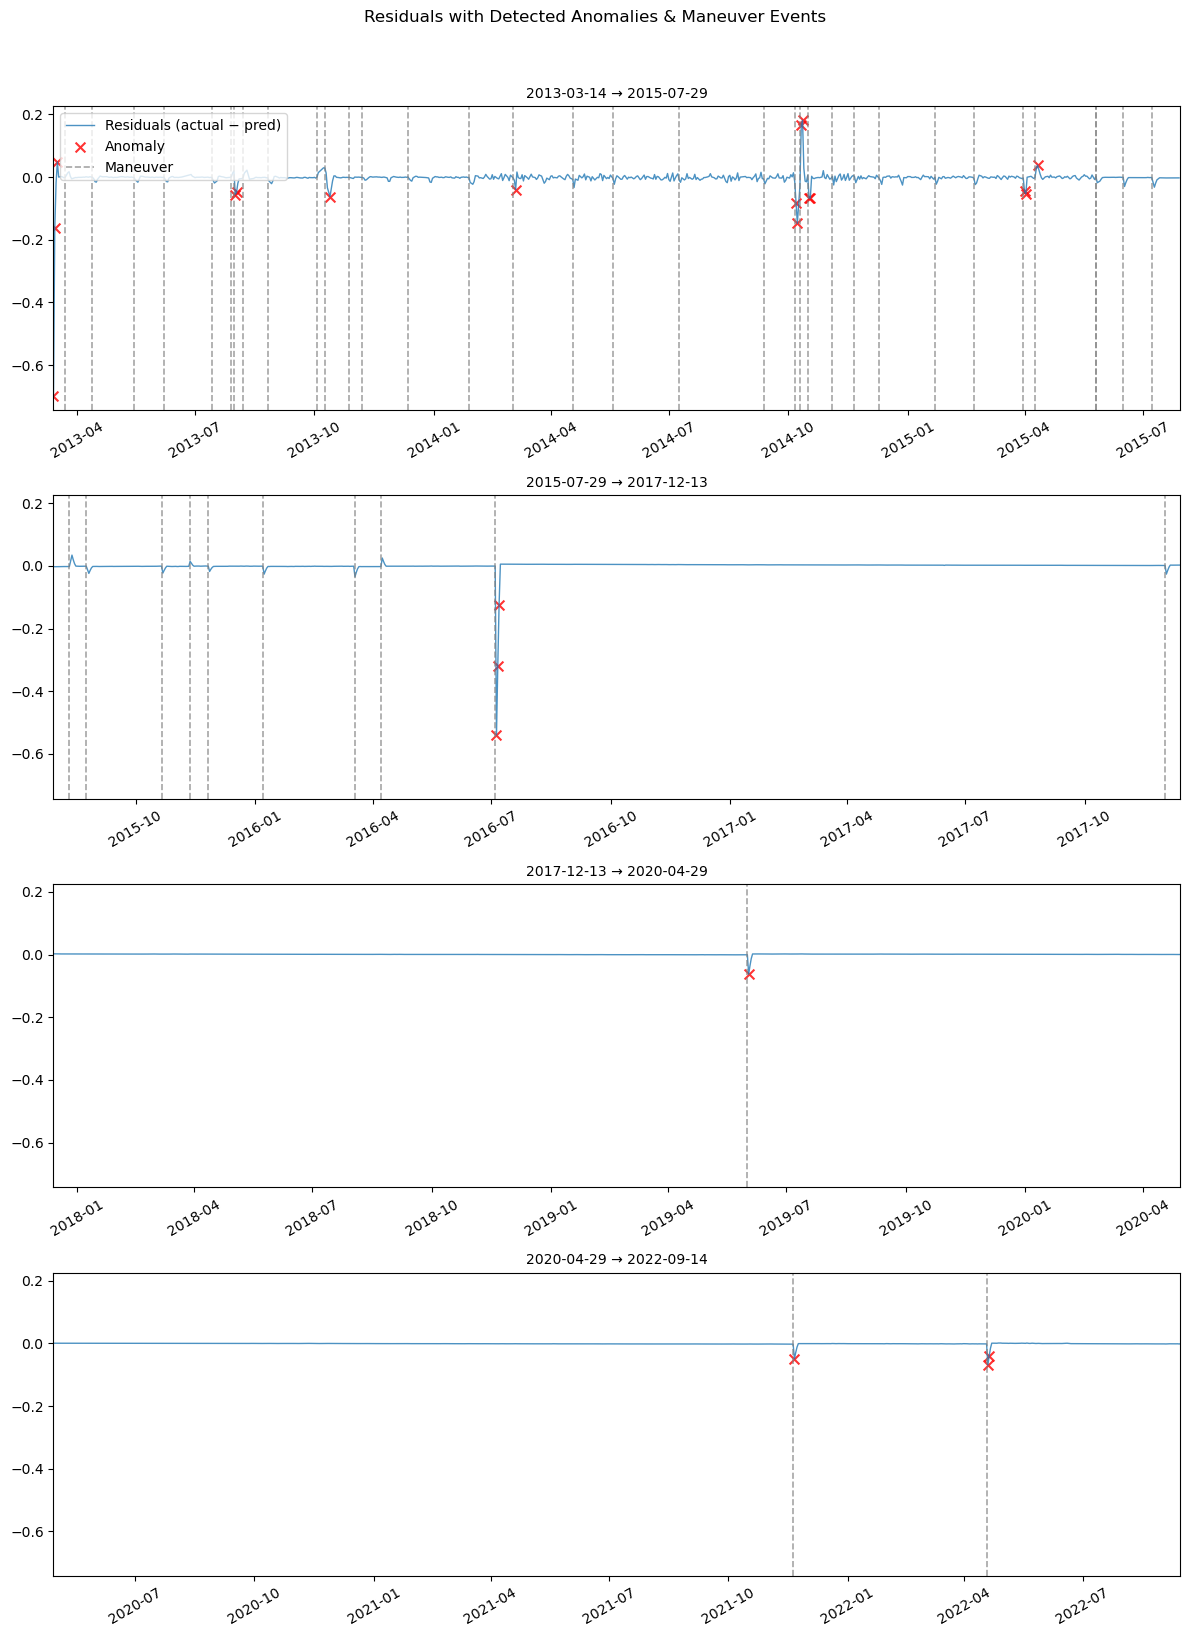

In [38]:
# residuals

fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharey=True)

for ax, (seg_start, seg_end) in zip(axes, intervals):
    segment = lstm_pred.loc[seg_start:seg_end]
    
    ax.plot(
        segment.index, segment['residual'],
        label='Residuals (actual − pred)',
        color='C0', alpha=0.8, linewidth=1.0
    )

    idx1 = anomalies.loc[seg_start:seg_end].index
    ax.scatter(
        idx1, segment.loc[idx1, 'residual'],
        color='red', marker='x', s=50, alpha=0.8,
        label='Anomaly'
    )
    
    first = True
    for dt in manoeuvre_dates:
        if seg_start <= dt <= seg_end:
            ax.axvline(
                x=dt, color='gray', linestyle='--',
                linewidth=1.2, alpha=0.7,
                label='Maneuver' if first else None
            )
            first = False
    
    ax.set_xlim(seg_start, seg_end)
    ax.set_title(f"{seg_start.date()} → {seg_end.date()}", fontsize=10)
    ax.tick_params(axis='x', rotation=30)
    if ax is axes[0]:
        ax.legend(loc='upper left')

fig.suptitle(
    "Residuals with Detected Anomalies & Maneuver Events",
    y=1.02, fontsize=12
)
plt.tight_layout()
plt.show()

# Record num of man and anomlies

In [39]:
# records num of anomlies and man
man_df   = man.copy()             # man
anom_idx = anomalies.index        # outliers index

man_days  = pd.to_datetime(man_df['median_day_time']).dt.normalize()
anom_days = anom_idx.normalize()

anom_set = set(anom_days)

# check deteced in +- n days range
n = 3 

matched_manoeuvres = []
unmatched_manoeuvres = []

for d in man_days:
    window = set(d + pd.to_timedelta(offset, unit='D') for offset in range(-n, n+1))
    
    if window & anom_set:
        matched_manoeuvres.append(d)
    else:
        unmatched_manoeuvres.append(d)

summary = pd.DataFrame({
    "category": [
        "total_manoeuvres",
        "total_anomalies",
        f"manoeuvres_matched_within_±{n}d",
        f"manoeuvres_unmatched_within_±{n}d"
    ],
    "count": [
        len(man_days),
        len(anom_days),
        len(matched_manoeuvres),
        len(unmatched_manoeuvres)
    ]
})

summary

,category,count
0,total_manoeuvres,62
1,total_anomalies,23
2,manoeuvres_matched_within_±3d,13
3,manoeuvres_unmatched_within_±3d,49


In [40]:
# summary.to_csv("result/saral_lstm_result.csv", index=False)